# Bounding box detection - Racoon data (Object Localization)


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

Please note that each image in the dataset has one racoon.

### Import the necessary libraries

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

### Change directory

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
path='/content/gdrive/My Drive/Colab Notebooks/Residency 9/Internal Lab'
os.chdir(path)

In [18]:
!unrar e images_racoon.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from images_racoon.rar

Extracting  raccoon-1.jpg                                                  0%  OK 
Extracting  raccoon-10.jpg                                                 0%  OK 
Extracting  raccoon-100.jpg                                                0%  OK 
Extracting  raccoon-101.jpg                                                1%  OK 
Extracting  raccoon-102.jpg                                                1%  OK 
Extracting  raccoon-103.jpg                                                2%  OK 
Extracting  raccoon-104.jpg                                                2%  OK 
Extracting  raccoon-105.jpg                                                2%  OK 
Extracting  raccoon-106.jpg                                                2%  OK 
Extracting  raccoon-107.jpg                                         

### Load the training data from train.csv file

In [0]:
train_df=pd.read_csv(path+'/train_labels.csv')

In [13]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [14]:
train_df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128

#### Build a Batch Generator

The batch generator should do the following:

1. Take batch_size and dataframe (build from csv file above) as input
2. Build random row indexes equal to batch size from the dataframe
3. Based on random indexes created above, read the dataframe to do following:
   - Read image and resize the image to 128x128
   - Convert it to numpy array
   - Read bounding box co-ordinates from dataframe for this image
   - Resize co-ordinates as we have resized the image
   - 'yield' batch of images and batch of co-ordinates
   
Please note that there is no classification task here as all images do have racoon's in them.

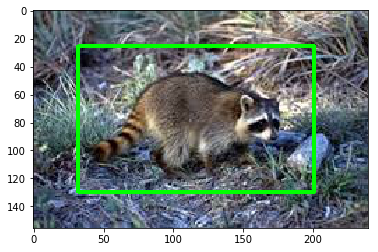

In [23]:
#Pickup a random image number
img_num = np.random.randint(0, train_df.shape[0])

#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(train_df.loc[img_num,'filename'])
cv2.rectangle(img, 
             (train_df.loc[img_num, 'xmin'],train_df.loc[img_num, 'ymin']),
             (train_df.loc[img_num, 'xmax'],train_df.loc[img_num, 'ymax']), 
             (0,255,0),
             2)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.imshow(img)
plt.show()

In [0]:
def batch_generator(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays
        #1. To hold image input
        batch_images = np.zeros(shape=(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
        #Classification Labels 
        #batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'filename'], 
                                                        target_size=(IMAGE_SIZE, IMAGE_SIZE))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array

            #Read image classification label & convert to one hot vector
            #cl_label = df.loc[image_nums[i], 'Label']
            #cl_label = tf.keras.utils.to_categorical(cl_label, num_classes=len(num_classes))
            #batch_labels[i] = cl_label

            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'width']
            img_height = df.loc[image_nums[i], 'height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * IMAGE_SIZE/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * IMAGE_SIZE/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * IMAGE_SIZE/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * IMAGE_SIZE/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        batch_images = tf.keras.applications.mobilenet.preprocess_input(batch_images)
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/IMAGE_SIZE

        #Return batch - use yield function to make it a python generator
        yield batch_images, [batch_bboxes]

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense,Conv2D,Reshape
from keras.models import Model

In [295]:
model1=MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False, weights=None)
for layer in model1.layers:
  layer.trainable=False

x=model1.layers[-1].output
x=Conv2D(4,kernel_size=4,name="coords")(x)
x=Reshape((4,))(x)
#x=Dense(4,name="fc",activation='relu')(x)

model1=Model(input=model1.input,output=[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  # Remove the CWD from sys.path while we load stuff.


### Define a custom metric function IoU which calculates Intersection Over Union

In [0]:
from keras.backend import epsilon

In [0]:
def calculate_iou(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [0]:
opt=adam(lr=0.000001)
model1.compile(optimizer=opt,loss='mse',metrics=[IoU])

In [0]:
train_generator = batch_generator(train_df)

In [0]:
batchsize=20

In [298]:
model1.fit_generator(train_generator, 
                          epochs=30,
                          steps_per_epoch= train_df.shape[0]//batchsize)

Epoch 1/30
8/8 [==============================] - 7s 818ms/step - loss: 1.6600 - IoU: 0.3786
Epoch 2/30
8/8 [==============================] - 1s 75ms/step - loss: 1.6002 - IoU: 0.3742
Epoch 3/30
8/8 [==============================] - 1s 164ms/step - loss: 1.4979 - IoU: 0.1542
Epoch 4/30
8/8 [==============================] - 1s 169ms/step - loss: 1.3884 - IoU: 0.2816
Epoch 5/30
8/8 [==============================] - 1s 158ms/step - loss: 1.3118 - IoU: 0.2748
Epoch 6/30
8/8 [==============================] - 1s 166ms/step - loss: 1.2854 - IoU: 0.1230
Epoch 7/30
8/8 [==============================] - 1s 162ms/step - loss: 1.3339 - IoU: 0.2377
Epoch 8/30
8/8 [==============================] - 1s 171ms/step - loss: 1.2957 - IoU: 0.2445
Epoch 9/30
8/8 [==============================] - 1s 168ms/step - loss: 1.1076 - IoU: 0.1882
Epoch 10/30
8/8 [==============================] - 1s 166ms/step - loss: 1.1663 - IoU: 0.1995
Epoch 11/30
8/8 [==============================] - 1s 171ms/step - los

### Pick a test image from the given data

In [0]:
#Pickup a random image number
img_num = np.random.randint(0, train_df.shape[0])

#Read the image 
img = cv2.imread(train_df.loc[img_num,'filename'])

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
img=cv2.resize(img,(128,128),interpolation = cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=tf.keras.applications.mobilenet.preprocess_input(img)

### Predict the coordinates of the bounding box for the given test image

In [0]:
region=model.predict(img.reshape(1,128,128,3))

In [0]:
image_width=img.shape[0]
image_height=img.shape[1]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

In [0]:
def predict_and_draw(image_num, df):

    #Load image
    img = tf.keras.preprocessing.image.load_img(df.loc[image_num, 'filename'])
    w, h = img.size

    #Read actual label and bounding box
    #act_class = df.loc[image_num, 'Class']
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]
    
    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((IMAGE_SIZE, IMAGE_SIZE)) 
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)
    #3. Normalize image data
    input_array = tf.keras.applications.mobilenet.preprocess_input(input_array)

    #Prediction
    pred = model1.predict(input_array)
    #Get classification and regression predictions
    #label_pred, bbox_pred = pred[0][0], pred[1][0]
    bbox_pred=pred[0]
    print(bbox_pred)
    #Get Label with highest probability
    #pred_class = label_class_dict[np.argmax(label_pred)]

    #print('Real Label :', act_class, '\nPredicted Label: ', pred_class)
    
    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'filename'])
    #Draw actual bounding box
    img = cv2.rectangle(img, (xmin, ymin), 
                        (xmax, ymax), (0,0,255), 2)
    #Draw predicted bounding box
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 2)

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

[0.00889014 0.00754021 0.02138313 0.02047541]


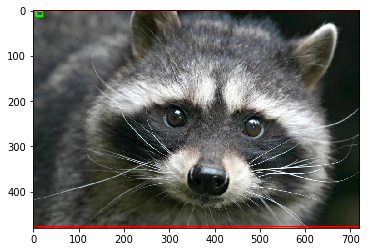

In [288]:
predict_and_draw(85,train_df)

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [0]:
#Already Mounted

#### Change your present working directory

### Load your data file

In [0]:
ts_df=pd.read_csv('daily-minimum-temperatures-in-me.csv',index_col='Date')

In [199]:
ts_df.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


#### Plot data

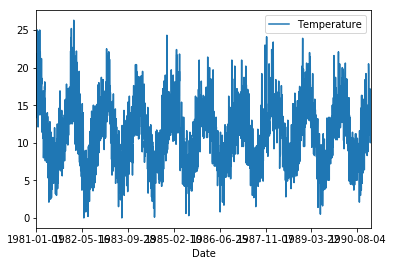

In [200]:
ts_df.plot()

#### Descibe your dataframe

In [201]:
ts_df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [202]:
ts_df.isnull().sum()

Temperature    0
dtype: int64

#### Drop null values

In [0]:
#There are no Null Values

#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ed99afc18>]],
      dtype=object)

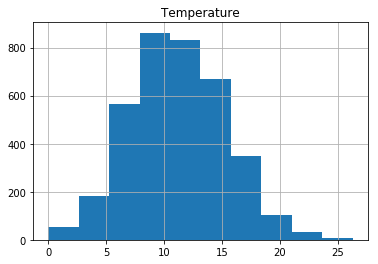

In [203]:
ts_df.hist()

#### Check the maximum and minimum values

In [204]:
ts_df.max()

Temperature    26.3
dtype: float64

In [205]:
ts_df.min()

Temperature    0.0
dtype: float64

### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
dataset = ts_df.astype('float32')

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

#### Check the maximum and minimum values of scaled data

In [212]:
scaled.min()

0.0

In [213]:
scaled.max()

1.0

#### Look into some of the scaled values

In [214]:
scaled[:10]

array([[0.7870723 ],
       [0.68060837],
       [0.71482889],
       [0.55513311],
       [0.60076048],
       [0.60076048],
       [0.60076048],
       [0.66159696],
       [0.82889733],
       [0.7604563 ]])

### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]


#### Print train and test size

In [217]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [219]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.7870723]
Y 1
0.6806083702582986
1
X 1 to 2
[0.68060837]
Y 2
0.7148288890658444
2
X 2 to 3
[0.71482889]
Y 3
0.5551331104563756
3
X 3 to 4
[0.55513311]
Y 4
0.6007604809535642
4
X 4 to 5
[0.60076048]
Y 5
0.6007604809535642
5
X 5 to 6
[0.60076048]
Y 6
0.6007604809535642
6
X 6 to 7
[0.60076048]
Y 7
0.6615969628626882
7
X 7 to 8
[0.66159696]
Y 8
0.8288973334395067
8
X 8 to 9
[0.82889733]
Y 9
0.7604562958244149
9
X 9 to 10
[0.7604563]
Y 10
0.6159696286268815
10
X 10 to 11
[0.61596963]
Y 11
0.5057034439755123
11
X 11 to 12
[0.50570344]
Y 12
0.6349810360224919
12
X 12 to 13
[0.63498104]
Y 13
0.817490518011246
13
X 13 to 14
[0.81749052]
Y 14
0.9505703697805186
14
X 14 to 15
[0.95057037]
Y 15
0.7870722951873749
15
X 15 to 16
[0.7870723]
Y 16
0.7832699992037001
16
X 16 to 17
[0.78327]
Y 17
0.9429657778131689
17
X 17 to 18
[0.94296578]
Y 18
0.6730038508137127
18
X 18 to 19
[0.67300385]
Y 19
0.5893536292639215
19
X 19 to 20
[0.58935363]
Y 20
0.6920152582093231
20
X 20 to 21
[0.6

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [227]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM

In [0]:
batch_size = 1 

model = Sequential()

model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


### Summarize your model

In [225]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [228]:
model.fit(X_train, y_train, epochs=100, batch_size=batch_size, verbose=2, shuffle=True)

W0804 12:20:41.692168 140127123904384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
 - 15s - loss: 0.0240
Epoch 2/100
 - 13s - loss: 0.0155
Epoch 3/100
 - 13s - loss: 0.0133
Epoch 4/100
 - 13s - loss: 0.0124
Epoch 5/100
 - 13s - loss: 0.0122
Epoch 6/100
 - 13s - loss: 0.0119
Epoch 7/100
 - 13s - loss: 0.0114
Epoch 8/100
 - 13s - loss: 0.0108
Epoch 9/100
 - 13s - loss: 0.0105
Epoch 10/100
 - 13s - loss: 0.0103
Epoch 11/100
 - 13s - loss: 0.0102
Epoch 12/100
 - 13s - loss: 0.0102
Epoch 13/100
 - 13s - loss: 0.0102
Epoch 14/100
 - 13s - loss: 0.0102
Epoch 15/100
 - 13s - loss: 0.0102
Epoch 16/100
 - 13s - loss: 0.0102
Epoch 17/100
 - 13s - loss: 0.0101
Epoch 18/100
 - 13s - loss: 0.0102
Epoch 19/100
 - 13s - loss: 0.0102
Epoch 20/100
 - 13s - loss: 0.0102
Epoch 21/100
 - 13s - loss: 0.0101
Epoch 22/100
 - 13s - loss: 0.0101
Epoch 23/100
 - 13s - loss: 0.0102
Epoch 24/100
 - 13s - loss: 0.0102
Epoch 25/100
 - 13s - loss: 0.0101
Epoch 26/100
 - 13s - loss: 0.0101
Epoch 27/100
 - 13s - loss: 0.0102
Epoch 28/100
 - 13s - loss: 0.0101
Epoch 29/100
 - 13s - loss: 0

## Make Predictions and Evaluate your model

In [0]:
import math
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(X_train, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

In [0]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [231]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.61 RMSE
Test Score: 2.44 RMSE


## Plot the results

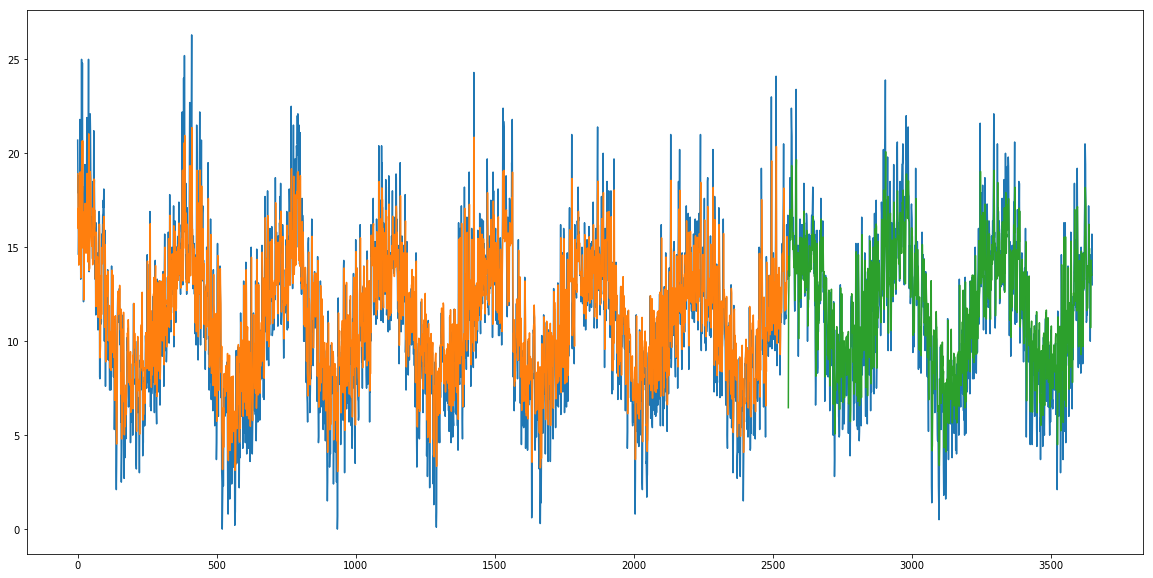

In [232]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()